# Report 4

## Mafalda Borges

In [2]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint, EvalExponentialPdf, MakePoissonPmf, MakeMixture
import thinkplot

This next problem was taken from Allen Downey's notebook.

## World Cup Problem

In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

Note: for this one you will need a new suite that provides a Likelihood function that takes as data the time between goals, rather than the number of goals in a game. 

I am going to assume that a Poisson process is a reasonable model to use for soccer games just like for hockey games, which assumes that goal scoring can be modeled by some fixed rate $\lambda $. This means probability of scoring a goal during any point in the game is the same.

Given the distribution is a Poisson process then the distribution of time between goals is exponential with $\lambda $ being the goal scoring rate. We know that the first goal was scored at 11 minutes and the next goal occured 12 minutes later. 

First I will create a class that inherits from Suite and creates a likelihood function.

In [3]:
class Soccer(Suite):
    """Hypotheses about goal scoring rates"""
    def Likelihood(self, data, hypo):
        """Likelihood of data under hypothesis
        hypo: goal rate in (goals/game)
        data: time between goals"""
        
        x = data
        lam = hypo/90.0
        like = EvalExponentialPdf(x, lam)
        return like

This is returns the likelihood of the data given that the data is the time between goals in minutes and hypo is the predicted goal scoring rate in goals per game. 

Now we need to construct a prior. The average number of goals scored per game for the tournament was 2.7. I am going to construct a uniform distribution and update it so it has a mean of 2.7 goals. 

Data from: https://www.statista.com/statistics/269031/goals-scored-per-game-at-the-fifa-world-cup-since-1930/

2.7252648918157445

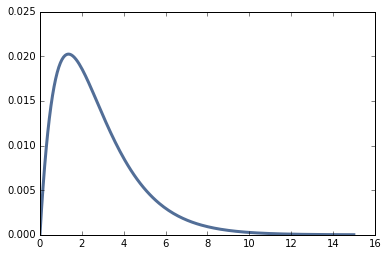

In [4]:
hypos = np.linspace(0, 15, 201)
suite = Soccer(hypos)
suite.Update(66)
thinkplot.Pdf(suite)
suite.Mean()

Now we can update our distribution with information from the actual game. The first goal was scored in 11 minutes, and the next goal game was about 12 minutes later.

4.0420735012024362

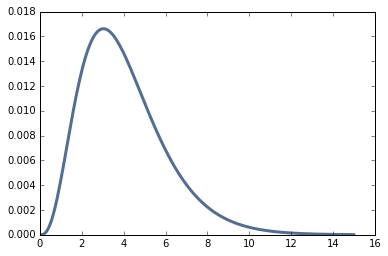

In [5]:
suite.Update(11)
suite.Update(12)
thinkplot.Pdf(suite)
suite.Mean()

Now my models believes that about 4 goals will be scored per game.

We have to predict how many goals will be scored in the remaining amount of time by Germany. We will use the posterior distribution of $\lambda$ to create a predictive distribution for the number of goals that will be scored in the remaining time.

In [6]:
def GoalsScored(suite, time_left):
    """Plots the predictive distribution for additional number of goals.

    suite: posterior distribution of lambda in goals per game
    time_left: how much of the game is left in minutes
    """
    metapmf = Pmf()
    for lam, prob in suite.Items():
        lt = lam * time_left / 90
        pred = MakePoissonPmf(lt, 15)
        metapmf[pred] = prob

    mix = MakeMixture(metapmf)
    return mix

mix = GoalsScored(suite, 90-23)

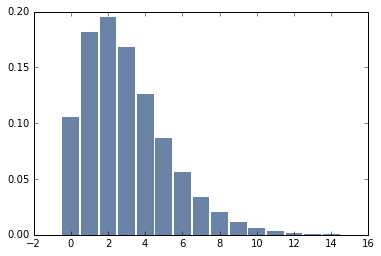

In [7]:
thinkplot.Hist(mix)


In [8]:
mix.ProbGreater(4)

0.2224156339145239

In [9]:
mix.Mean()

3.0070627149748601

My model predicts a 22% chance of scoring 5 or more times which seems unreasonably high for a soccer game. 

# Rain Problem

This problem comes from Allen Downey.

You're about to get on a plane to Seattle. You want to know if you should bring an umbrella. You call 3 random friends of yours who live there and ask each independently if it's raining. Each of your friends has a 2/3 chance of telling you the truth and a 1/3 chance of messing with you by lying. All 3 friends tell you that "Yes" it is raining. What is the probability that it's actually raining in Seattle?


To set up this problem we know that there is a 2/3 chance of each of the 3 friends telling the truth. All three friends said that it was raining, and we want to know if it is actually raining. We can set up a class that returns the likelihood that it is raining, given a response of yes or no.

Now we need to think about how much it actually rains in Seattle. Contrary to popular belief, it is more often not raining than raining. We were provided data from http://www.wrcc.dri.edu/htmlfiles/hrsofppt.html which gives us the mean number of hours of rain per month and the total amount per year. Seattle rain patterns change drastically during the seasons. In the winter you can expect to never see the sun, while the summer actually produces some sunny days. 

Now I need calculate the probability of raining given the month. We are given the total number of hours of rain per month, and we can calculate the number of hours in a month.


In [66]:
prob_Jan = 137.0/(31*24)
prob_Feb = 107.0/(28*24)
prob_Mar = 104.0/(31*24)
prob_Apr = 74.0/(30*24)
prob_May = 48.0/(31*24)
prob_Jun = 37.0/(30*24)
prob_Jul = 21.0/(31*24)
prob_Aug = 25.0/(31*24)
prob_Sep = 40.0/(30*24)
prob_Oct = 71.0/(31*24)
prob_Nov = 124.0/(30*24)
prob_Dec = 134.0/(31*24)

#I am using 1 to represent Jan, 2 for February...

probMonth = {1: prob_Jan, 2: prob_Feb, 3: prob_Mar, 4: prob_Apr, 5: prob_May, 6: prob_Jun, 7: prob_Jul, 8: prob_Aug, 9: prob_Sep, 10: prob_Oct, 11: prob_Nov, 12: prob_Dec}


In [69]:
class Rain(Suite):
    def Likelihood(self, data, hypo):
        """data: yes or no reponse by friends
        hypo: whether or not it is raining during a certain month"""
        probTruth = 2.0/3
        hypo = month
        if data == 'yes':
            return probTruth * probMonth[month]
        else:
            return (1-probTruth) * probMonth[month]

In [70]:
rain_month = Rain(probMonth)
rain_month.Print()

1 0.145337896718
2 0.125674088481
3 0.110329498238
4 0.08112047082
5 0.0509213068792
6 0.04056023541
7 0.0222780717596
8 0.0265215139996
9 0.043848903146
10 0.0753210997588
11 0.135931599752
12 0.142155315038


Above shows us the probability that it is raining in any given month. next we need to update the distribution with the data or the three yes responses.  

1 0.145337896718
2 0.125674088481
3 0.110329498238
4 0.08112047082
5 0.0509213068792
6 0.04056023541
7 0.0222780717596
8 0.0265215139996
9 0.043848903146
10 0.0753210997588
11 0.135931599752
12 0.142155315038


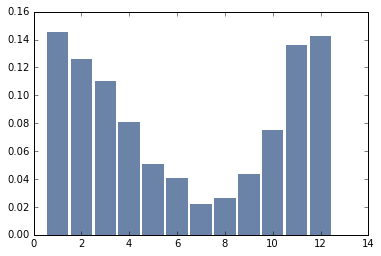

In [71]:
rain_month.UpdateSet(['yes', 'yes', 'yes'])
rain_month.Print()
thinkplot.Hist(rain_month)

When taking into account the weather, it seems very unlikely that your friends are telling the truth, or you just picked a very good day to call on. Your friends also just may think it is funny that you are thinking about bringing an umbrella to Seattle, because the joke goes that you can always spot the tourist if he is carrying an umbrella. 

# Extended Paintball

The following problem was taken from Allen Downey.

In our simple model, the opponent is equally likely to shoot in any direction. As an exercise, let’s consider improvements to this model. The analysis in this chapter suggests that a shooter is most likely to hit the closest wall. But in reality, if the opponent is close to a wall, he is unlikely to shoot at the wall because he is unlikely to see a target between himself and the wall.
Design an improved model that takes this behavior into account. Try to find a model that is more realistic, but not too complicated.

First we will take the paintball class given by Allen. 

In [72]:
class Paintball(Suite, Joint):
    """Represents hypotheses about the location of an opponent."""

    def __init__(self, alphas, betas, locations):
        """Makes a joint suite of parameters alpha and beta.

        Enumerates all pairs of alpha and beta.
        Stores locations for use in Likelihood.

        alphas: possible values for alpha
        betas: possible values for beta
        locations: possible locations along the wall
        """
        self.locations = locations
        pairs = [(alpha, beta) 
                 for alpha in alphas 
                 for beta in betas]
        Suite.__init__(self, pairs)

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: pair of alpha, beta
        data: location of a hit

        Returns: float likelihood
        """
        alpha, beta = hypo
        x = data
        pmf = MakeLocationPmf(alpha, beta, self.locations)
        like = pmf.Prob(x)
        return like

We will however modify the make location Pmf such that it bcomes less likely that a shooter will shoot the wall close to him. We will multiply the probability by the distance he is away, because he is likely to shoot things further away from him. 

In [73]:
def MakeLocationPmf(alpha, beta, locations):
    """Computes the Pmf of the locations, given alpha and beta. 

    Given that the shooter is at coordinates (alpha, beta),
    the probability of hitting any spot is inversely proportionate
    to the strafe speed.

    alpha: x position
    beta: y position
    locations: x locations where the pmf is evaluated

    Returns: Pmf object
    """
    pmf = Pmf()
    for x in locations:
        distance = ((alpha-x)**2 + beta**2)**.5
        prob = (1.0*distance) / StrafingSpeed(alpha, beta, x) 
        pmf.Set(x, prob)
    pmf.Normalize()
    return pmf

In [74]:
def StrafingSpeed(alpha, beta, x):
    """Computes strafing speed, given location of shooter and impact.

    alpha: x location of shooter
    beta: y location of shooter
    x: location of impact

    Returns: derivative of x with respect to theta
    """
    theta = math.atan2(x - alpha, beta)
    speed = beta / math.cos(theta)**2
    return speed

In [75]:
alphas = range(0, 31)
betas = range(1, 51)
locations = range(0, 31)

suite = Paintball(alphas, betas, locations)
suite.UpdateSet([15, 16, 18, 21])

1.441072655985378e-06

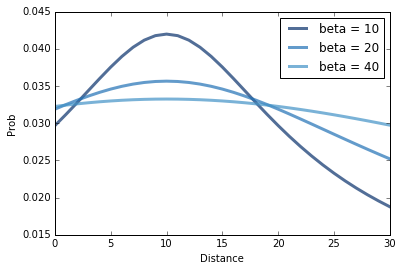

In [76]:
locations = range(0, 31)
alpha = 10
betas = [10, 20, 40]
thinkplot.PrePlot(num=len(betas))

for beta in betas:
    pmf = MakeLocationPmf(alpha, beta, locations)
    pmf.label = 'beta = %d' % beta
    thinkplot.Pdf(pmf)

thinkplot.Config(xlabel='Distance',
                ylabel='Prob')

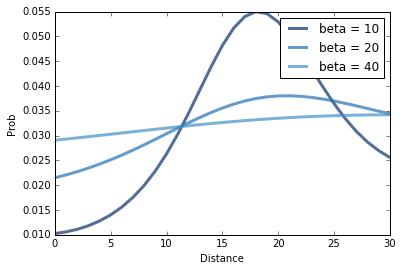

In [77]:
betas = [10, 20, 40]
thinkplot.PrePlot(num=len(betas))

for beta in betas:
    cond = suite.Conditional(0, 1, beta)
    cond.label = 'beta = %d' % beta
    thinkplot.Pdf(cond)

thinkplot.Config(xlabel='Distance',
                ylabel='Prob')


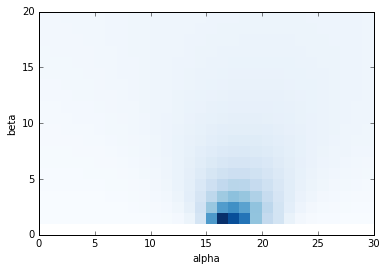

In [78]:
thinkplot.Contour(suite.GetDict(), contour=False, pcolor=True)

thinkplot.Config(xlabel='alpha',
                ylabel='beta',
                axis=[0, 30, 0, 20])


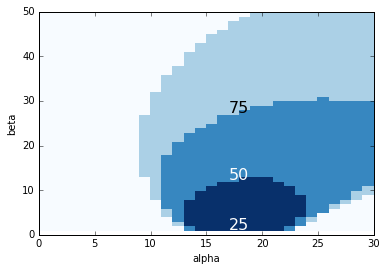

In [79]:
d = dict((pair, 0) for pair in suite.Values())

percentages = [75, 50, 25]
for p in percentages:
    interval = suite.MaxLikeInterval(p)
    for pair in interval:
        d[pair] += 1

thinkplot.Contour(d, contour=False, pcolor=True)
thinkplot.Text(17, 4, '25', color='white')
thinkplot.Text(17, 15, '50', color='white')
thinkplot.Text(17, 30, '75')

thinkplot.Config(xlabel='alpha',
                   ylabel='beta',
                   legend=False)


Given that we think the shooter is further from the wall we are less of his position. The further he gets from the wall the less we know about him. 

# Original Problem

You decided to grow zucchini garden for the second year because they are very hard to kill and can freeze well so you can later make bread with them. You made very copious notes of how long it took last year for the zucchinis to grow after planting them. You found that for one plant 2 zuchinis came up on the 36th day, 1 on the 38th day, 2 on the 39th day, 2 on the 43rd day, 1 on the 44th day, 3 on the 46th day, 2 on the 49th day, and 1 on the 50th day. On the 51 day there was a frost and killed the remaining 6 zucchini which would have become ripe later. You have been asked to make zucchini bread for your friend's party that is 44 days away. She wants you to make 50 loaves of bread, so how many plants should you plant?

Based on last year, you know that each plant produces about 20 zucchini's in a season and it takes 1 zucchini per loaf of bread. We can use a Weibull model to see how many plants to plant. It takes in parameters lambda and k to make a curve. Because I do not know lamda and k I will use a uniform distribution for both and iterate through the possible combinations.


In [93]:
from thinkbayes2 import EvalWeibullPdf, EvalWeibullCdf, MakeWeibullPmf
from thinkbayes2 import MakeMixture
from itertools import product

class Zucchini(Suite, Joint):
    """lam: parameter lambda in zucchinis per day
    k: parameter
    return: probability density
    """
    def Likelihood(self, data, hypo):
        lam, k = hypo
        if lam == 0:
            return 0
        flag, x = data
        if flag == 'eq':
            like = EvalWeibullPdf(x, lam, k)
        elif flag == 'gt':
            like = 1 - EvalWeibullCdf(x, lam, k)
        else:
            raise ValueError('Invalid data')
        return like

In [87]:
lams = np.linspace(0, 100, 101)
ks = np.linspace(0, 20, 101)
data = [("eq", 36), ("eq",36), ("eq", 38), ("eq", 39), ("eq", 39),
       ("eq",43), ("eq", 43), ("eq", 44), ("eq", 46), ("eq", 46),
       ("eq", 46), ("eq", 49), ("eq", 49), ("eq", 50), ("gt", 51), 
       ("gt", 51), ("gt", 51), ("gt", 51), ("gt", 51), ("gt", 51)]

In [88]:
zucchini = Zucchini(product(lams, ks))
zucchini.UpdateSet(data)

6.2804705181752108e-26

I can look at the marginal distributions, lamda and k, of my Weibull distribution.

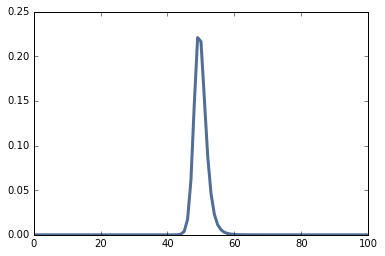

In [89]:
pmf_lam = zucchini.Marginal(0)
thinkplot.Pdf(pmf_lam)

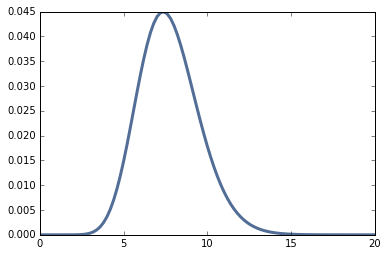

In [90]:
pmf_ks = zucchini.Marginal(1)
thinkplot.Pdf(pmf_ks)

Next I will make a predictive model, which will tell me how many plants I will need to have 50 ripe zucchinis on the 43rd day. 

In [107]:
numberPlants = 8
zucchiniPerPlant = 20
n = numberPlants * zucchiniPerPlant
t_return = 44


In [108]:
metapmf = Pmf()
for (lam, k), prob in zucchini.Items():
    p = EvalWeibullCdf(t_return, lam, k)
    pmf = MakeBinomialPmf(n,p)
    metapmf[pmf] = prob

50

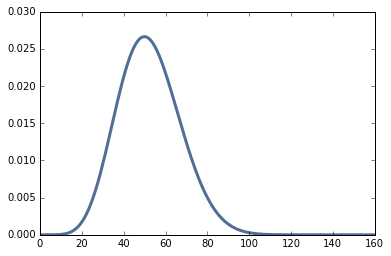

In [109]:
mix = MakeMixture(metapmf)
thinkplot.Pdf(mix)
mix.MAP()

Growing 8 plants should get you 50 zucchinis on the 43rd day, though  you will probably be sick of making zucchini bread afterwards. 